**Lernd** is my implementation of $\partial$ILP framework. The original $\partial$ILP paper $-$
[Learning Explanatory Rules from Noisy Data](https://arxiv.org/abs/1711.04574).

In the `intro_predecessor.ipynb` notebook, the $predecessor$ problem is quite simple and does not showcase the
capabilities of **Lernd**.

For a more difficult problem, let's solve $even$ (this time without noise). **Lernd** should come up with the definition of predicate $even$ given
just a successor predicate $succ$ and a few examples.

This is not a trivial problem, because an auxiliary predicate has to be invented and the solution has recursion in it.
An example solution could be:

$target(A) \leftarrow zero(A)$

$target(A) \leftarrow target(B),pred(B,A)$

$pred(A,B) \leftarrow succ(A,C),succ(C,B)$

Here $pred$ is the auxiliary predicate, true if $A+2=B$. There may be variations.


Let's define the problem:

In [1]:
import os

import numpy as np
import tensorflow as tf
from IPython.core.display import clear_output
from matplotlib import pyplot as plt

from lernd.classes import ILP, LanguageModel, ProgramTemplate
from lernd.lernd_loss import Lernd
from lernd.lernd_types import Constant, RuleTemplate
from lernd.main import generate_weight_matrices, extract_definitions, print_valuations
from lernd.util import get_ground_atom_probs, ground_atom2str, softmax, str2ground_atom, str2pred

os.environ['CUDA_VISIBLE_DEVICES'] = ''

target_pred = str2pred('even/1')
zero_pred = str2pred('zero/1')
succ_pred = str2pred('succ/2')
preds_ext = [zero_pred, succ_pred]
constants = [Constant(str(i)) for i in range(11)]
language_model = LanguageModel(target_pred, preds_ext, constants)

# Program template
aux_pred = str2pred('pred/2')
aux_preds = [aux_pred]
rules = {
    target_pred: (RuleTemplate((0, False)), RuleTemplate((1, True))),
    aux_pred: (RuleTemplate((1, False)), None)
}
forward_chaining_steps = 6
program_template = ProgramTemplate(aux_preds, rules, forward_chaining_steps)

# ILP problem
ground_zero = str2ground_atom('zero(0)')
background = [ground_zero] + [str2ground_atom(f'succ({i},{i + 1})') for i in range(10)]
positive = [str2ground_atom(f'even({i})') for i in range(0, 11, 2)]
negative = [str2ground_atom(f'even({i})') for i in range(1, 10, 2)]
ilp_problem = ILP(language_model, background, positive, negative)

Let's see the background knowledge and examples:

In [2]:
print('Background axioms:')
print(', '.join(map(ground_atom2str, background)))

print('\nPositive examples:')
print(', '.join(map(ground_atom2str, positive)))

print('\nNegative examples:')
print(', '.join(map(ground_atom2str, negative)))

Background axioms:
zero(0), succ(0,1), succ(1,2), succ(2,3), succ(3,4), succ(4,5), succ(5,6), succ(6,7), succ(7,8), succ(8,9), succ(9,10)

Positive examples:
even(0), even(2), even(4), even(6), even(8), even(10)

Negative examples:
even(1), even(3), even(5), even(7), even(9)


We can now run **Lernd**.

Note that in this problem mini batching is used (taking random 30% of examples at every training step). This has a
dramatic effect on performance as it helps to avoid local minima.

Step 500 loss: -0.0, mini_batch loss: -0.0



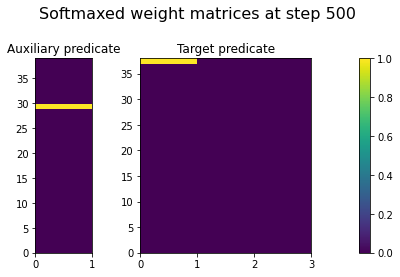

In [3]:
lernd_model = Lernd(ilp_problem, program_template, mini_batch=0.3)
weights = generate_weight_matrices(lernd_model.clauses)

losses = []
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.5)

for i in range(1, 501):
    loss_grad, loss, valuation, full_loss = lernd_model.grad(weights)
    optimizer.apply_gradients(zip(loss_grad, list(weights.values())))
    loss_float = float(full_loss.numpy())
    mb_loss_float = float(loss.numpy())
    losses.append(loss_float)
    if i % 10 == 0:
        print(f'Step {i} loss: {loss_float}, mini_batch loss: {mb_loss_float}\n')
        fig, axs = plt.subplots(ncols=3, gridspec_kw={'width_ratios': [1, 3, 0.2]})
        fig.subplots_adjust(top=0.8, wspace=0.6)
        fig.suptitle(f'Softmaxed weight matrices at step {i}', fontsize=16)
        im0 = axs[0].pcolormesh(softmax(weights[aux_pred]).numpy(), cmap='viridis', vmin=0, vmax=1)
        axs[0].set_title('Auxiliary predicate')
        im1 = axs[1].pcolormesh(np.transpose(softmax(weights[target_pred]).numpy()), cmap='viridis', vmin=0, vmax=1)
        axs[1].set_title('Target predicate')
        fig.colorbar(im0, cax=axs[2])
        plt.show()
        if i != 500:
            clear_output(wait=True)

Let's plot the loss to see how it went.

Text(0, 0.5, 'Value')

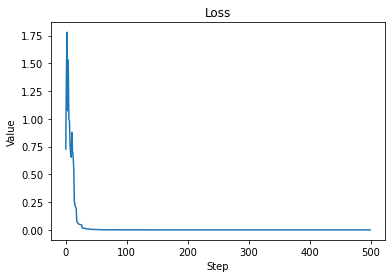

In [4]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title('Loss')
ax.set_xlabel('Step')
ax.set_ylabel('Value')

Finally let's extract the results:

In [5]:
extract_definitions(lernd_model.clauses, weights)
ground_atom_probs = get_ground_atom_probs(valuation, lernd_model.ground_atoms)
print_valuations(ground_atom_probs)

clause_prob_threshold: 0.1

Clause learnt:
With probability (confidence): 1.0
pred(A,B)<-succ(A,C), succ(C,B)

clause_prob_threshold: 0.1

Clause learnt:
With probability (confidence): 1.0
even(A)<-zero(A), zero(A)
even(A)<-even(B), pred(B,A)

Valuations of ground atoms (only those >0.01 for readability):
zero(0) - 1.0
succ(0,1) - 1.0
succ(1,2) - 1.0
succ(2,3) - 1.0
succ(3,4) - 1.0
succ(4,5) - 1.0
succ(5,6) - 1.0
succ(6,7) - 1.0
succ(7,8) - 1.0
succ(8,9) - 1.0
succ(9,10) - 1.0
pred(0,2) - 1.0
pred(1,3) - 1.0
pred(2,4) - 1.0
pred(3,5) - 1.0
pred(4,6) - 1.0
pred(5,7) - 1.0
pred(6,8) - 1.0
pred(7,9) - 1.0
pred(8,10) - 1.0
even(0) - 1.0
even(2) - 1.0
even(4) - 1.0
even(6) - 1.0
even(8) - 1.0
even(10) - 1.0


I found that **Lernd** is able to solve this problem in 500 training steps 78% of the time (i. e. loss lower than 1e-4 was
reached in 78 tries, out of a 100, and in 74 cases loss was exactly 0). Other times system gets stuck in a local
minimum, weights oscillating. This could potentially be solved by splitting background axioms and examples into possible
worlds, as suggested in the original paper.

In the next notebook we'll run **Lernd** on data with mislabelled examples.